<a href="https://colab.research.google.com/github/pranathadoddy/down-syndrome/blob/main/Copy_of_Resnet90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import time

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torchvision import datasets

from torchvision import datasets
from torchvision import transforms

from torchvision import models

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from PIL import Image

## Download DataSet

In [2]:
!pip install kaggle

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!mkdir ~/.kaggle

In [5]:
! cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
! kaggle datasets download mervecayli/detection-of-down-syndrome-in-children

Dataset URL: https://www.kaggle.com/datasets/mervecayli/detection-of-down-syndrome-in-children
License(s): unknown
 33% 10.0M/30.5M [00:00<00:00, 46.3MB/s]
100% 30.5M/30.5M [00:00<00:00, 108MB/s] 


In [8]:
! unzip detection-of-down-syndrome-in-children.zip

Archive:  detection-of-down-syndrome-in-children.zip
  inflating: downSyndorme/downSyndrome/down_1.jpg  
  inflating: downSyndorme/downSyndrome/down_10.jpg  
  inflating: downSyndorme/downSyndrome/down_100.jpg  
  inflating: downSyndorme/downSyndrome/down_1000.jpg  
  inflating: downSyndorme/downSyndrome/down_1001.jpg  
  inflating: downSyndorme/downSyndrome/down_1002.jpg  
  inflating: downSyndorme/downSyndrome/down_1003.jpg  
  inflating: downSyndorme/downSyndrome/down_1004.jpg  
  inflating: downSyndorme/downSyndrome/down_1005.jpg  
  inflating: downSyndorme/downSyndrome/down_1006.jpg  
  inflating: downSyndorme/downSyndrome/down_1007.jpg  
  inflating: downSyndorme/downSyndrome/down_1008.jpg  
  inflating: downSyndorme/downSyndrome/down_1009.jpg  
  inflating: downSyndorme/downSyndrome/down_101.jpg  
  inflating: downSyndorme/downSyndrome/down_1010.jpg  
  inflating: downSyndorme/downSyndrome/down_1011.jpg  
  inflating: downSyndorme/downSyndrome/down_1012.jpg  
  inflating: downSy

# Clean Datasets

In [9]:
BATCH_SIZE = 128
LEARNING_RATE = 0.001
NUM_EPOCHS = 100

DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

In [10]:
down_syndrome_folder = "/content/downSyndorme/downSyndrome"
healthy_folder = "/content/healty/healty"

# Function to extract filenames and assign class
def create_df_from_folder(folder, class_value):
    files = os.listdir(folder)
    df = pd.DataFrame({'dosya': files, 'class': class_value})
    return df

# Create DataFrames for each folder
down_syndrome_df = create_df_from_folder(down_syndrome_folder, 1)
healthy_df = create_df_from_folder(healthy_folder, 0)

# Concatenate the DataFrames
df = pd.concat([down_syndrome_df, healthy_df], ignore_index=True)

df.set_index('dosya', inplace=True)
df


,class
dosya,
down_44.jpg,1
down_637.jpg,1
down_1117.jpg,1
down_148.jpg,1
down_174.jpg,1
...,...
healty_43.jpg,0
healty_1179.jpg,0
healty_1177.jpg,0


In [11]:
class_counts = df.groupby('class').size()

class_counts

class
0    1499
1    1500
dtype: int64

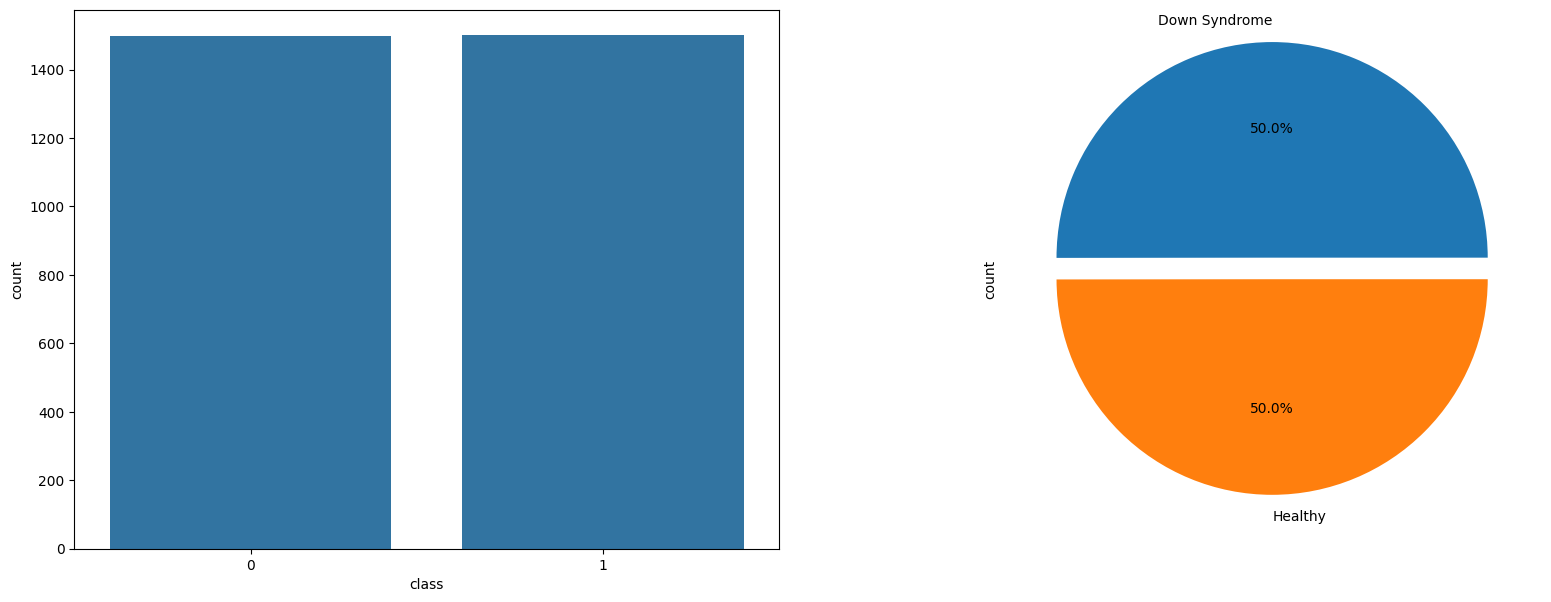

In [12]:
fig, ax = plt.subplots(1,2, figsize=(20,7))

sns.countplot(x=df["class"], ax=ax[0])
df["class"].value_counts().plot.pie(explode=[0.1, 0],autopct="%1.1f%%",labels=["Down Syndrome", "Healthy"], ax=ax[1])

plt.show()

## Train Test Split

In [13]:
train, test_df = train_test_split(df, test_size = 0.3, random_state=1, shuffle=True)
validate, test = train_test_split(test_df, test_size=0.33, random_state=1, shuffle=True)

In [14]:
train.shape, validate.shape, test.shape

((2099, 1), (603, 1), (297, 1))

In [15]:
train.to_csv('downsyndrome_train.csv')
validate.to_csv('downsyndrome_valid.csv')
test.to_csv('downsyndrome_test.csv')

## Data Loader

In [16]:
class ImageDownSyndromeDataset(Dataset):

    def __init__(self, csv_path, img_dir, transform=None):

        df = pd.read_csv(csv_path, index_col=0)
        self.img_dir = img_dir
        self.csv_path = csv_path
        self.img_names = df.index.values
        self.y = df['class'].values
        self.transform = transform

    def __getitem__(self, index):
        directory = 'healty/healty'
        if self.y[index] == 1:
           directory = 'downSyndorme/downSyndrome'

        img = Image.open(os.path.join(self.img_dir+directory,
                                      self.img_names[index]))
        img = img.convert('RGBA')

        if self.transform is not None:
            img = self.transform(img)


        label = self.y[index]

        return img, label

    def __len__(self):
        return self.y.shape[0]

In [22]:
custom_transform = transforms.Compose([transforms.CenterCrop((250, 250)),
                                       transforms.Resize((224, 224)),
                                       transforms.RandomRotation(degrees=(30,60)),
                                       #transforms.Grayscale(),
                                       transforms.ToTensor()])


train_dataset = ImageDownSyndromeDataset(csv_path='downsyndrome_train.csv',
                              img_dir= '/content/',
                                         transform=custom_transform)

valid_dataset = ImageDownSyndromeDataset(csv_path='downsyndrome_valid.csv',
                              img_dir='/content/',
                              transform=custom_transform)

test_dataset = ImageDownSyndromeDataset(csv_path='downsyndrome_test.csv',
                             img_dir='/content/',
                              transform=custom_transform)


train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=4)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=4)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=4)

In [23]:
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [24]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out




class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 4
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.layer5 = self._make_layer(block, 1024, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1, padding=2)
        self.fc = nn.Linear(4096, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):

        x = self.conv1(x)

        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)

        x = self.layer2(x)

        x = self.layer3(x)

        x = self.layer4(x)

        x = self.layer5(x)

        x = self.avgpool(x)

        x = x.view(x.size(0), -1)
        logits = self.fc(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas



def resnet34(num_classes, grayscale):
    """Constructs a ResNet-34 model."""
    model = ResNet(block=BasicBlock,
                   layers=[3, 4, 6, 3],
                   num_classes=2,
                   grayscale=grayscale)
    return model

In [25]:
torch.manual_seed(1)

model = resnet34(num_classes=2, grayscale=False)

model.to(DEVICE)

cost_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [27]:
import copy
def compute_accuracy(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):

        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    print(correct_pred.float()/num_examples * 100)
    return correct_pred.float()/num_examples * 100



trainingEpoch_loss = []
validationEpoch_loss = []

trainingEpoch_accuracy = []
validationEpoch_accuracy = []

torch.backends.cuda.max_split_size_mb = 256
torch.cuda.empty_cache()

best_validation_accuracy = 0
best_model_state_dict = copy.deepcopy(model.state_dict())
patience = 10  # Number of epochs with no improvement after which training will be stopped
epochs_no_improve = 0

for epoch in range(NUM_EPOCHS):
    model.train()

    for batch_idx, (features, targets) in enumerate(train_loader):

        features = features.to(DEVICE)
        targets = targets.to(DEVICE)

        logits, probas = model(features)
        cost = cost_fn(logits, targets)
        optimizer.zero_grad()

        cost.backward()

        optimizer.step()

        if not batch_idx % 5:
            print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f'
                   %(epoch+1, NUM_EPOCHS, batch_idx,
                     len(train_loader), cost))

    with torch.set_grad_enabled(False): # save memory during inference
        train_accuracy = compute_accuracy(model, train_loader, device=DEVICE)
        valid_accuracy = compute_accuracy(model, valid_loader, device=DEVICE)

        if valid_accuracy > best_validation_accuracy:
             best_validation_accuracy = valid_accuracy
             best_model_state_dict = copy.deepcopy(model.state_dict())
             epochs_no_improve = 0
        else:
             epochs_no_improve += 1

        print('Epoch: {} | Train: {} | Valid: {}'.format(
              epoch+1,
              train_accuracy,
              valid_accuracy))
        trainingEpoch_accuracy.append(train_accuracy)
        validationEpoch_accuracy.append(valid_accuracy)

        if epochs_no_improve >= patience:
          print(f'Early stopping after {epoch+1} epochs')
          break

model.load_state_dict(best_model_state_dict)

Epoch: 001/100 | Batch 0000/0017 | Cost: 0.5151
Epoch: 001/100 | Batch 0005/0017 | Cost: 0.4572
Epoch: 001/100 | Batch 0010/0017 | Cost: 0.5343
Epoch: 001/100 | Batch 0015/0017 | Cost: 0.5558
tensor(70.6527, device='cuda:0')
tensor(69.1542, device='cuda:0')
Epoch: 1 | Train: 70.65269470214844 | Valid: 69.15422821044922
Epoch: 002/100 | Batch 0000/0017 | Cost: 0.6025
Epoch: 002/100 | Batch 0005/0017 | Cost: 0.5008
Epoch: 002/100 | Batch 0010/0017 | Cost: 0.4664
Epoch: 002/100 | Batch 0015/0017 | Cost: 0.4971
tensor(76.6555, device='cuda:0')
tensor(70.8126, device='cuda:0')
Epoch: 2 | Train: 76.65554809570312 | Valid: 70.8125991821289
Epoch: 003/100 | Batch 0000/0017 | Cost: 0.4723
Epoch: 003/100 | Batch 0005/0017 | Cost: 0.6531
Epoch: 003/100 | Batch 0010/0017 | Cost: 0.5715
Epoch: 003/100 | Batch 0015/0017 | Cost: 0.5494
tensor(74.4640, device='cuda:0')
tensor(72.9685, device='cuda:0')
Epoch: 3 | Train: 74.46402740478516 | Valid: 72.96849060058594
Epoch: 004/100 | Batch 0000/0017 | Cos

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78439beffd00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    Exception ignored in: self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x78439beffd00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__

      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
self._shutdown_workers()    
if w.is_alive():
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
        assert self._parent_pid == os.getpid(), 'can only test a child process'if w.is_alive():

  File "/usr/lib/python3.10/multiprocessing/process.py", line 1

Epoch: 009/100 | Batch 0005/0017 | Cost: 0.4462
Epoch: 009/100 | Batch 0010/0017 | Cost: 0.4196
Epoch: 009/100 | Batch 0015/0017 | Cost: 0.3850


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78439beffd00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78439beffd00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

tensor(84.0400, device='cuda:0')


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78439beffd00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


tensor(79.1045, device='cuda:0')
Epoch: 9 | Train: 84.0400161743164 | Valid: 79.10447692871094
Epoch: 010/100 | Batch 0000/0017 | Cost: 0.3938
Epoch: 010/100 | Batch 0005/0017 | Cost: 0.4393
Epoch: 010/100 | Batch 0010/0017 | Cost: 0.3885
Epoch: 010/100 | Batch 0015/0017 | Cost: 0.4093
tensor(84.6594, device='cuda:0')
tensor(81.0945, device='cuda:0')
Epoch: 10 | Train: 84.65936279296875 | Valid: 81.09452819824219
Epoch: 011/100 | Batch 0000/0017 | Cost: 0.3513
Epoch: 011/100 | Batch 0005/0017 | Cost: 0.3021
Epoch: 011/100 | Batch 0010/0017 | Cost: 0.2791
Epoch: 011/100 | Batch 0015/0017 | Cost: 0.2990
tensor(83.0872, device='cuda:0')
tensor(77.7778, device='cuda:0')
Epoch: 11 | Train: 83.0871810913086 | Valid: 77.77777862548828
Epoch: 012/100 | Batch 0000/0017 | Cost: 0.5229
Epoch: 012/100 | Batch 0005/0017 | Cost: 0.3897
Epoch: 012/100 | Batch 0010/0017 | Cost: 0.3210
Epoch: 012/100 | Batch 0015/0017 | Cost: 0.3433
tensor(85.6598, device='cuda:0')
tensor(82.5871, device='cuda:0')
Epoc

<All keys matched successfully>

<function matplotlib.pyplot.show(close=None, block=None)>

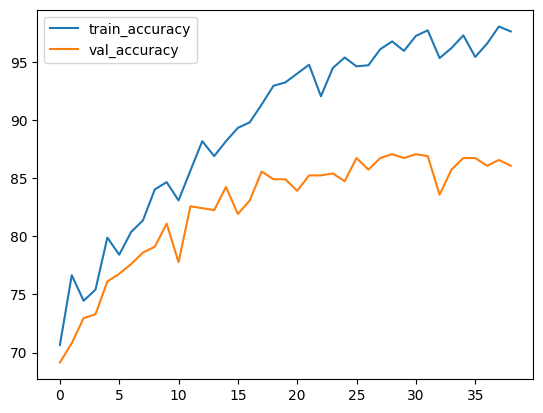

In [28]:
training_accuracy =  torch.tensor(trainingEpoch_accuracy, device = 'cpu').numpy()

validation_accuracy = torch.tensor(validationEpoch_accuracy, device = 'cpu').numpy()

plt.plot(training_accuracy, label='train_accuracy')
plt.plot(validation_accuracy,label='val_accuracy')
plt.legend()
plt.show

In [29]:
model.eval()
with torch.set_grad_enabled(False): # save memory during inference
    print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader, device=DEVICE)))

tensor(86.5320, device='cuda:0')
Test accuracy: 86.53%


In [30]:
predictions = []
targets_list = []

model.eval()

with torch.set_grad_enabled(False):  # Disable gradient calculation
    for features, targets in test_loader:
        for feature, target in zip(features, targets):
            logits, probas = model(feature[None].to(DEVICE))
            predictions.append(torch.argmax(probas).item())
            targets_list.append(target.item())

In [31]:
import torch
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(targets_list, predictions, average='weighted')
recall = recall_score(targets_list, predictions, average='weighted')
f1 = f1_score(targets_list, predictions, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.8721
Recall: 0.8721
F1 Score: 0.8721


In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm=confusion_matrix(targets_list,predictions)
cm

array([[131,  19],
       [ 19, 128]])